# Population Figure

In [9]:
from drn_interactions.umap import umap_spikes
from drn_interactions.decoding.plots import EEGDecodeLoader
from drn_interactions.transforms.brain_state_transforms import STFTPreprocessor
from drn_interactions.plots.heatmaps import heatmap, similarity_map, long_raster, state_indicator
from drn_interactions.plots.umap import plot_umap
from drn_interactions.config import Config
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme(context="paper", style="ticks")


import warnings
warnings.simplefilter("ignore", category=UserWarning)  # matplotlib user warnings

In [2]:
loader = EEGDecodeLoader()
sessions, neurons  = loader.load_metadata()

In [3]:
spikes, states, df_fft = loader.load_session_data(sessions[3], t_stop=1802)

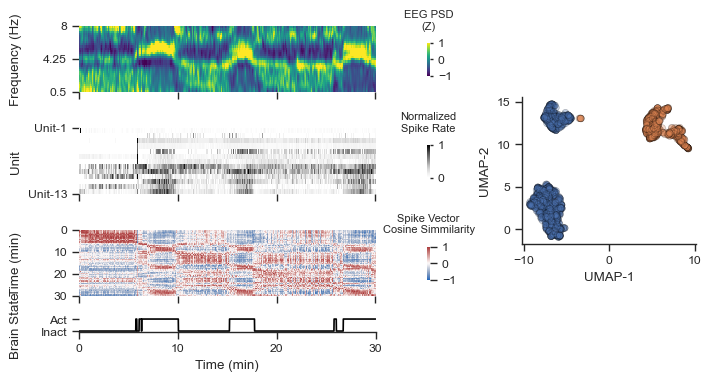

In [12]:
fig = plt.figure(figsize=(7, 3.7), constrained_layout=True)
fig_time, fig_umap = fig.subfigures(
    1, 2, width_ratios=[1, 0.5],    
    )

## Time Series Figure
gs_fig_time = fig_time.add_gridspec(
    4, 
    1, 
    height_ratios=[0.5, 0.5, 0.5, 0.1,], 
    hspace=0.15
)

# Spectrogram
preprocessor = STFTPreprocessor(t_stop=1802)
dfp = preprocessor(df_fft)
ax_spec = fig_time.add_subplot(gs_fig_time[0])
heatmap(
    dfp, 
    heatmap_kwargs=dict(cmap="viridis", vmin=-1, vmax=1, cbar_kws=dict(shrink=0.5, aspect=10, pad=0.15)),
    ax=ax_spec,
    locater_x=plt.MultipleLocator(300),
    locater_y=plt.LinearLocator(3),
    tick_params=dict(labelrotation=0, length=5),
    yticklabels_kwargs=dict(labels=[8, 4.25, 0.5]),
    cbar_title_kwargs=dict(label="EEG PSD\n(Z)", pad=10, fontsize="small"),
    cbar_tick_params=dict(length=2),
    cbar_tick_locater=plt.LinearLocator(3)
)
ax_spec.set_ylabel("Frequency (Hz)")

# Spikes
ax_spikes = fig_time.add_subplot(gs_fig_time[1])
long_raster(
    spikes, 
    ax=ax_spikes,
    minmax=True,
    heatmap_kwargs=dict(cmap="Greys", vmin=0, vmax=1, cbar_kws=dict(shrink=0.5, aspect=10, pad=0.15)),
    locater_x=plt.MultipleLocator(600),
    locater_y=plt.LinearLocator(2),
    tick_params=dict(labelrotation=0, length=5),
    yticklabels_kwargs=dict(labels=["Unit-1", f"Unit-{len(spikes.columns)}"]),
    cbar_title_kwargs=dict(label="Normalized\nSpike Rate", pad=10, fontsize="small"),
    cbar_tick_locater=plt.LinearLocator(2),
    cbar_ticklabel_kwargs=dict(labels=["0", "1"]),
    cbar_tick_params=dict(length=2),
)
ax_spikes.set_ylabel("Unit")

# Similarity Map
ax_sim = fig_time.add_subplot(gs_fig_time[2])
similarity_map(
    spikes, 
    z=True, 
    ax=ax_sim,
    heatmap_kwargs=dict(cmap="vlag", vmin=-1, vmax=1, cbar_kws=dict(shrink=0.5, aspect=10, pad=0.15)),
    locater_x=plt.MultipleLocator(600),
    locater_y=plt.MultipleLocator(600),
    tick_params=dict(labelrotation=0, length=5),
    yticklabels_kwargs=dict(labels=["", 0, 10, 20, 30]),
    cbar_title_kwargs=dict(label="Spike Vector\nCosine Simmilarity", pad=10, fontsize="small"),
    )
ax_sim.set_ylabel("Time (min)")

# State Indicator
ax_states = fig_time.add_subplot(gs_fig_time[3])
state_indicator(
    states, 
    ax=ax_states, 
    order=("sw", "act"),
    locater_x=plt.MultipleLocator(600),
    formater_x=plt.FuncFormatter(lambda x, _: f"{x / 60:.0f}"),
    tick_params=dict(length=5),
    ytickslabs=["Inact", "Act"]
    )
ax_states.set_ylabel("Brain\nState")
ax_states.set_xlabel("Time (min)")

fig_time.align_ylabels()

## UMAP Figure
gs = fig_umap.add_gridspec(3, 1, height_ratios=[0.3, 0.5, 0.3])
ax_umap = fig_umap.add_subplot(gs[1])
df_umap = umap_spikes(
    spikes, 
    y=states, 
    y_transformer=lambda x: np.where(x == "sw", 1, 0)
    )
plot_umap(
    df_umap,
    y=states,
    ax=ax_umap,
    alpha=0.3
)

fig.savefig(Config.fig_dir / "bs - decoding - example and umap.png", dpi=300, bbox_inches="tight")